In [1]:
import pandas as pd
import re
import string
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk import sent_tokenize
from pywsd.utils import lemmatize_sentence
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from nltk import word_tokenize
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

Warming up PyWSD (takes ~10 secs)... took 4.830173015594482 secs.


In [63]:
df = pd.read_csv('Emotion_classify_Data.csv', encoding='latin-1')
random_state = 42
labels = df['Emotion']

In [64]:
labels = labels.map({'fear': 0, 'anger': 1, 'joy': 2})

In [65]:
df['Comment'] = df['Comment'].apply(lambda x: sent_tokenize(x))
df['Comment'] = df['Comment'].apply(lambda x: [clean_text(s) for s in x])

In [75]:
tagged_data = [TaggedDocument(words=word_tokenize(doc[0]),
                              tags=[str(i)]) for i, doc in enumerate(df['Comment'])]

In [76]:
model = Doc2Vec()
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df['Comment'].apply(lambda x: str(x[0])))



  (0, 2318)	0.4377946585961953
  (0, 6333)	0.3218747945164998
  (0, 2854)	0.08263907638284912
  (0, 1879)	0.41947362137972544
  (0, 7478)	0.44547688485006304
  (0, 5330)	0.252897126981499
  (0, 3517)	0.33010756312888306
  (0, 6788)	0.38803028564104103
  (1, 359)	0.6495286327680815
  (1, 4459)	0.4045846619896386
  (1, 3141)	0.5728988776878812
  (1, 3810)	0.26426606619168347
  (1, 2854)	0.1279614344273125
  (2, 4653)	0.2239340414268402
  (2, 4845)	0.27859392353233836
  (2, 5810)	0.3766443574373461
  (2, 36)	0.36559978105852053
  (2, 161)	0.2652157991200991
  (2, 7814)	0.21538360913503146
  (2, 2859)	0.2506523025993543
  (2, 2090)	0.41095194523172573
  (2, 7322)	0.2769159531198503
  (2, 8723)	0.2714542333503176
  (2, 6983)	0.312901511326718
  (3, 5703)	0.3652642543877654
  :	:
  (5934, 2636)	0.1941820514332297
  (5934, 3320)	0.187654486192783
  (5934, 3235)	0.14718432907233525
  (5934, 3294)	0.17002962088578788
  (5934, 2622)	0.15769660482403652
  (5934, 3429)	0.23749614358012605
  (5934,

In [160]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(tfidf_matrix, labels, random_state=42)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(model.dv.vectors, labels, random_state=42)

In [61]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation + '’'))
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

In [113]:
reg = LogisticRegression()

In [114]:
reg.fit(X_train, y_train)

LogisticRegression()

In [170]:
reg_tf_idf = LogisticRegression()

In [171]:
reg_tf_idf.fit(X_train_, y_train_)

LogisticRegression()

In [172]:
y_pred_ = reg_tf_idf.predict(X_test_)
accuracy_score(y_test_, y_pred_)

0.9346801346801347

In [116]:
y_pred = reg.predict(X_test)

accuracy_score(y_test, y_pred)

0.38316498316498315

In [135]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}

In [136]:
gs_NB = GridSearchCV(estimator=LogisticRegression(),
                     param_grid=param_grid,
                     cv=5,
                     verbose=1,
                     scoring='accuracy',
                     )

In [137]:
gs_NB.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/Users/gd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gd/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [140]:
print(gs_NB.best_score_)
print(gs_NB.best_params_)

0.3733121476941702
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [141]:
y_pred = gs_NB.best_estimator_.predict(X_test)

In [142]:
accuracy_score(y_test, y_pred)

0.37777777777777777

In [143]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [144]:
X_ = pca.fit_transform(model.dv.vectors)

In [145]:
import matplotlib.pyplot as plt

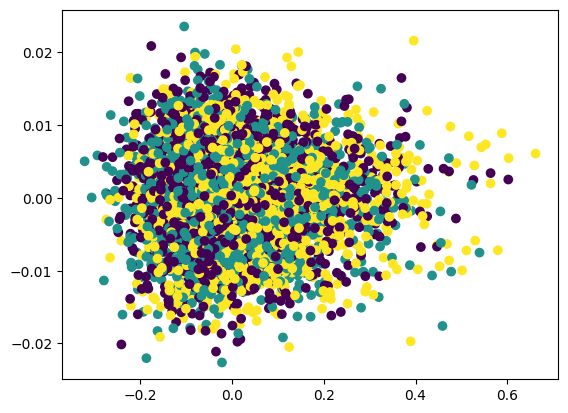

In [146]:

plt.scatter(X_[:, 0], X_[:, 1], c=labels)
plt.show()

In [182]:
from sklearn.decomposition import TruncatedSVD

clf = TruncatedSVD(2)
Xpca = clf.fit_transform(tfidf_matrix)

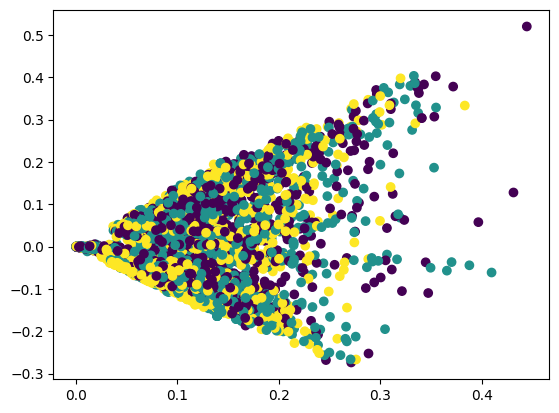

In [209]:
scatter = plt.scatter(Xpca[:, 0], Xpca[:, 1], c=labels)


plt.show()